In [849]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from math import exp, sqrt, log
from scipy.stats import norm

## Import Selected Dataset 

In [850]:
libor_data = pd.read_csv('LIBOR_3MTH.csv')
libor_data = libor_data[['Date', 'Close']]
libor_data['Close'] = libor_data['Close'].apply(lambda x: float(x.replace('"', '').replace('%', '')))

sigma_libor = libor_data['Close'].std()

## Monte Carlo Simulation 

Recall that the 2-Factor Hull-White Model follows: \
\begin{equation}
dr_t = (\theta_t + u_t - \bar{\alpha_t}r_t)dt + \sigma_{1,t}dW_{1,t} 
\end{equation}

\begin{equation}
du_t = -\bar{\beta_t}u_tdt + \sigma_{2,t}dW_{2,t}
\end{equation}

To model the 2 brownian motion - $W_1$ and $W_2$, we made use of the following property:
* $W_t - W_s \sim N(0,s)$

In [851]:
random.seed(999) # to ensure reproducibility of results

In [852]:
# 1 year of data
T = 1
no_of_steps = libor_data.shape[0]
dT = [T/no_of_steps*step for step in range(no_of_steps)]
time_steps = 1/libor_data.shape[0]
dB1 = [np.random.normal(loc=0, scale=sqrt(t)) for t in dT]
dB2 = [np.random.normal(loc=0, scale=sqrt(t)) for t in dT]

B1 = [0] + [sum(dB1[:i]) for i in range(1, no_of_steps)]
B2 = [0] + [sum(dB2[:i]) for i in range(1, no_of_steps)]

sigma1 = np.std(B1)
sigma2 = np.std(B2)

rho_bar = np.corrcoef(B1, B2)[0][1]

We will denote the following variables: \
$\alpha = \bar{\alpha}$ \
$\beta = \bar{\beta}$ \
$\sigma = \sqrt{\sigma_1^2 + \frac{\sigma_2^2}{(\bar{\beta}-\bar{\alpha})^2}+ 2\bar{\rho}\frac{\sigma_1 \sigma_2}{\bar{\beta}-\bar{\alpha}}}$ \
$\mathbf{n}=\frac{\sigma_2}{\bar{\alpha}-\bar{\beta}}$ \
$\rho = \frac{\sigma_1 \bar{\rho}-\mathbf{n}}{\sigma}$ 

In [853]:
# assume some values for alpha and beta
a, b = 15, 20
assert a-b != 0

In [854]:
# calculate the formula as per above
sigma = sqrt(sigma1**2 + sigma2**2/(a-b)**2 + 2*rho_bar*sigma1*sigma2/(b-a))
n = sigma2/(a-b)
rho = (sigma1*rho_bar-n)/sigma

We made use of these 2 equation from the paper:

\begin{equation}
x(t) = x(s) e^{-\alpha(t-s)} + M_x^T(s,t) + \sigma\int_s^t e^{-\alpha(t-u)}dW_{1,u}
\end{equation}

\begin{equation}
y(t) = y(s) e^{-\beta(t-s)} + M_y^T(s,t) + \sigma\int_s^t e^{-\beta(t-u)}dW_{2,u}
\end{equation}

with

\begin{equation}
M_x^T(s,t) = (\frac{\sigma^2}{\alpha^2} + \rho \frac{\sigma \mathbf{n}}{\alpha \beta})(1-e^{-\alpha(t-s)}) - \frac{\sigma^2}{2 \alpha^2}(e^{-\alpha(T-t)} - e^{-\alpha (T+t-2s)}) - \frac{\rho \sigma \mathbf{n}}{\beta(\alpha+\beta)}(e^{-\beta(T-t)}-e^{-\beta T - \alpha t + (\alpha+\beta)s})
\end{equation}

\begin{equation}
M_y^T(s,t) = (\frac{\mathbf{n}^2}{\beta^2} + \rho \frac{\sigma \mathbf{n}}{\alpha \beta})(1-e^{-\beta(t-s)}) - 
\frac{\mathbf{n}^2}{2 \beta^2}(e^{-\beta(T-t)} - e^{-\beta (T+t-2s)}) - 
\frac{\rho \sigma \mathbf{n}}{\beta(\alpha+\beta)}(e^{-\alpha(T-t)}-e^{-\beta T - \beta t + (\alpha+\beta)s})
\end{equation}

to generate $r_t \sim N(\bar{r_t}, \sigma_{r_t})$ :

\begin{equation}
\mathbb{E} (r_t | \mathcal{F}) = x(s) e^{-\alpha(t-s)} + y(s) e^{-\beta(t-s)} - M_x^T(s,t) - M_y^T(s,t) + \phi(t)
\end{equation}

\begin{equation}
Var(r_t | \mathcal{F}) = \frac{\sigma^2}{2\alpha^2}(1-e^{-2\alpha(t-s)}) + \frac{\mathbf{n}^2}{2\beta^2}(1-e^{-2\beta(t-s)}) + 2\frac{\sigma \mathbf{n}}{\alpha + \beta}(1-e^{(\alpha + \beta)(t-s)})
\end{equation}

Recall that $\phi(t)$ is a function of $t$ that satisfy $\phi(0)=r_0$. For our ease of calculation, we define $\phi(t)$ as follows:
\begin{equation}
\phi(t) = r_0 e^{-0.1t}
\end{equation}

In [855]:
def MxT(s:int, t:int) -> float:
    term1 = ((sigma/a)**2+rho*sigma*n/(a*b))*(1-exp(-a*(t-s)))
    term2 = 0.5*(sigma/a)**2*(exp(-a*(T-t))-exp(-a*(T+t-2*s)))
    term3 = rho*sigma*n/b/(a+b)*(exp(-b*(T-t))-exp(-b*T-a*t+(a+b)*s))
    return term1-term2-term3

def MyT(s:int, t:int) -> float:
    term1 = ((n/b)**2+rho*sigma*n/(a*b))*(1-exp(-b*(t-s)))
    term2 = 0.5*(n/b)**2*(exp(-b*(T-t))-exp(-b*(T+t-2*s)))
    term3 = rho*sigma*n/a/(a+b)*(exp(-a*(T-t))-exp(-a*T-b*t+(a+b)*s))
    return term1-term2-term3

In [856]:
# created a new dataframe to work with
df_main = pd.DataFrame({
    's': [0] + dT[:len(dT) - 1],
    't': dT,
    'B1': B1,
    'B1s': 0,
    'dB1': dB1,
    'B2': B2,
    'B2s': 0,
    'dB2': dB2
})

In [857]:
df_main['phi_t'] = df_main['t'].apply(lambda x: exp(-0.1 * x))
df_main['MxT'] = df_main.apply(lambda x: MxT(x['s'], x['t']), axis=1)
df_main['xt'] = df_main.apply(lambda x: x['MxT'] + sigma * exp(-a * x['t']) * (x['B1'] - exp(-a * x['t']) * x['B1s']),
                              axis=1)
df_main['MyT'] = df_main.apply(lambda x: MyT(x['s'], x['t']), axis=1)
df_main['yt'] = df_main.apply(lambda x: x['MyT'] + sigma * exp(-b * x['t']) * (x['B2'] - exp(-b * x['t']) * x['B2s']),
                              axis=1)

# to add the first term to xt and yt
xt = df_main['xt'].tolist()
for i, x in enumerate(xt):
    if i == 0: continue
    xt[i] += xt[i - 1] * exp(-a * (df_main['t'][i] - df_main['s'][i]))

yt = df_main['yt'].tolist()
for i, y in enumerate(yt):
    if i == 0: continue
    yt[i] += yt[i - 1] * exp(-b * (df_main['t'][i] - df_main['s'][i]))
    
df_main['xt'] = xt
df_main['yt'] = yt

To simulate $r_t \sim N(\bar{r_t}, \sigma_{r_t})$ :

\begin{equation}
\mathbb{E} (r_t | \mathcal{F}) = x(s) e^{-\alpha(t-s)} + y(s) e^{-\beta(t-s)} - M_x^T(s,t) - M_y^T(s,t) + \phi(t)
\end{equation}

\begin{equation}
Var(r_t | \mathcal{F}) = \frac{\sigma^2}{2\alpha^2}(1-e^{-2\alpha(t-s)}) + \frac{\mathbf{n}^2}{2\beta^2}(1-e^{-2\beta(t-s)}) + 2\frac{\sigma \mathbf{n}}{\alpha + \beta}(1-e^{(\alpha + \beta)(t-s)})
\end{equation}

Recall that $\phi(t)$ is a function of $t$ that satisfy $\phi(0)=r_0$. For our ease of calculation, we define $\phi(t)$ as follows:
\begin{equation}
\phi(t) = r_0 e^{-0.1t}
\end{equation}

In [858]:
def gen_sigma_rt(t: float, s: float):
    term1 = 0.5 * sigma ** 2 / a ** 2 * (1 - exp(-2 * a * (t - s)))
    term2 = 0.5 * n ** 2 / b ** 2 * (1 - exp(-2 * b * (t - s)))
    term3 = 2 * sigma * n / (a + b) * (1 - exp((a + b) * (t - s)))
    return term1 + term2 + term3

In [859]:
# generating the mean (E_rt) and variance (sigma_rt)
df_main['E_rt'] = df_main.apply(lambda x: x['xt'] * exp(-a * (x['t'] - x['s'])) + x['yt'] * exp(-b * (x['t'] - x['s'])) -
                                          x['MxT'] - x['MyT'] + x['phi_t'], axis=1)
df_main['sigma_rt'] = df_main.apply(lambda x: gen_sigma_rt(t=x['t'], s=x['s']), axis=1)

In [860]:
# to start the simulation
df_main['rt'] = df_main.apply(lambda x: np.random.normal(loc=x['E_rt'], scale=x['sigma_rt']), axis=1)

# to ensure our interest rate do not fall into the negative range (pricing will fail)
df_main['rt'] = df_main['rt'].apply(lambda x: x if x > 0 else 0.01)

## Caplet Pricing Model

After simulating the interest rates using the 2-Factor Hull-White Model, we will now apply it into the Black-Scholes pricing model. We are pricing a caplet with strike $K=0.5$. The caplet expires in a year $T=1$.

\begin{equation}
\pi_{Call}(t) = S_t \Phi(d_1(t)) - Ke^{-r(T-t)} \Phi(d_2(t))
\end{equation}

where \
$d_1(t) = \frac{ln(\frac{S_t}{K}) + (r + \frac{1}{2}\sigma^2)(T-t)}{\sigma \sqrt{T-t}}$ and \
$d_2(t) = d_1(t) - \sigma \sqrt{T-t}$


In [861]:
def BS_pricing_model(S: float, K: float, r: float,
                     sigma: float, T: float, t: float,
                     call_option: bool = True) -> float:
    d2 = ((r + 0.5 * sigma ** 2) * (T - t) - log(K / S)) / (sigma * sqrt(T - t))
    d1 = d2 + sigma * sqrt(T - t)
    if call_option:
        return S * norm.cdf(d1) - K * exp(-r * (T - t)) * norm.cdf(d2)
    else:
        return K * exp(-r * (T - t)) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [862]:
K = 0.5

In [863]:
# Analytical Approach
libor_main = pd.DataFrame({
    't': df_main['t'],
    'libor': libor_data['Close']
})

libor_main['caplet_price_libor'] = libor_main.apply(
    lambda x: BS_pricing_model(S=x['libor'], K=K, r=0, sigma=sigma_libor, T=1, t=x['t']), axis=1)

In [864]:
# Monte Carlo Simulation
df_main['caplet_price'] = df_main.apply(lambda x: BS_pricing_model(S=x['rt'], K=K, r=0, sigma=sigma, T=1, t=x['t']),
                                        axis=1)

## Approach Comparison 

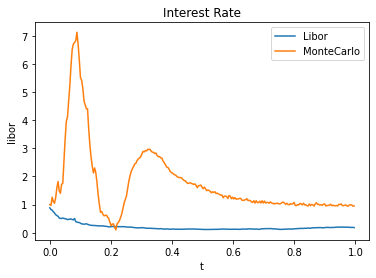

In [865]:
sns.lineplot(data=libor_main, x="t", y="libor")
sns.lineplot(data=df_main, x="t", y="rt")
plt.title("Interest Rate")
plt.legend(labels=["Libor","MonteCarlo"])
plt.show()

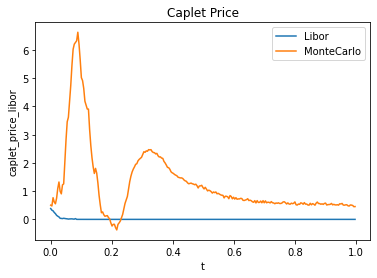

In [866]:
sns.lineplot(data=libor_main, x="t", y="caplet_price_libor")
sns.lineplot(data=df_main, x="t", y="caplet_price")
plt.title("Caplet Price")
plt.legend(labels=["Libor","MonteCarlo"])
plt.show()